# Generic Simulation of observed spectrum

- author : Sylvie Dagoret-Campagne
- date july 8 th 2017




** Notice it can handle several type of input objects **

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
from astropy.table import Table, Column
import re
import os

In [2]:
import pandas as pd

In [3]:
from matplotlib.backends.backend_pdf import PdfPages

In [4]:
import matplotlib 
matplotlib.rc('xtick', labelsize=25) 
matplotlib.rc('ytick', labelsize=25) 


### Import libradtan tools for simulation

In [5]:
import sys
sys.path.append('../spectrumsim/libradtransim')

In [6]:
from libsimulateTranspCTIOScattAbs import *

In [7]:
sys.path.append('../spectrumsim')
import libCTIOTransm as ctiosim 

In [8]:
sys.path.append('../humidity')
import humidity as hum
import libhumidity_ctio as humctio

### import pysynphot tools for CALSPEC SED

In [9]:
os.environ['PYSYN_CDBS']

'/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs'

In [10]:
import pysynphot as S
from astropy.io import ascii

### CTIO Properties

In [11]:
path_ctiodata='../spectrumsim/CTIOThroughput'
qe_filename='qecurve.txt'

### esthetic

In [12]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [13]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

In [14]:
def truncate(f, n):
    '''Truncates/pads a float f to n decimal places without rounding'''
    s = '{}'.format(f)
    if 'e' in s or 'E' in s:
        return '{0:.{1}f}'.format(f, n)
    i, p, d = s.partition('.')
    return '.'.join([i, (d+'0'*n)[:n]])

In [15]:
calspec_sed={'HD111980':'hd111980_stis_003.fits','HD205905':'hd205905_stis_003.fits','HD185975':'hd185975_stis_003.fits'}

In [16]:
object_name='HD111980'

## Define output file

In [17]:
outputfitsfile='spectra_'+object_name+'.fits'

## Definition of thermodynamic parameters

In [18]:
Pressure = 775.28625 # hPa  
Temperature = 0. # deg Celcius
Humidity=50.0

## Compute pwv required for libradtran

In [19]:
pwv=humctio.HRtoPWV(Humidity/100.,Pressure,Temperature+273.0)

In [20]:
print pwv

4.66402205415


## Get quantum efficiency

In [21]:
wl_qe,tr_qe=ctiosim. Get_QE()

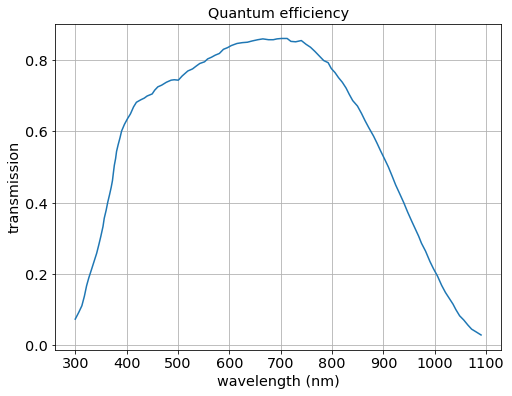

In [22]:
plt.plot(wl_qe,tr_qe)
plt.grid()
plt.title('Quantum efficiency')
plt.xlabel('wavelength (nm)')
plt.ylabel('transmission')

In [23]:
bp_ctio_qe = S.ArrayBandpass(wl_qe*10.,tr_qe, name='CTIO QE')

## Get mirror

In [24]:
wl_m,tr_m=ctiosim. Get_Mirror()

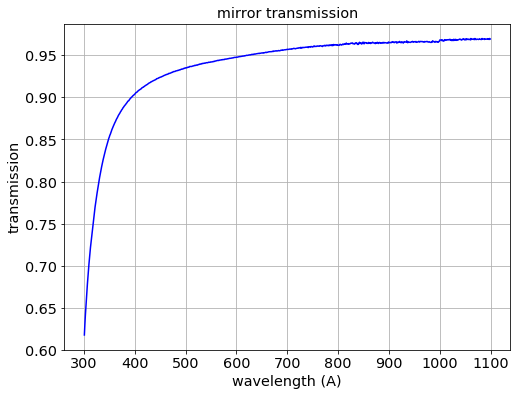

In [25]:
plt.plot(wl_m,tr_m,'b-')
plt.grid()
plt.title('mirror transmission')
plt.xlabel('wavelength (A)')
plt.ylabel('transmission')

In [26]:
bp_ctio_m = S.ArrayBandpass(wl_m*10.,tr_m*tr_m, name='CTIO Mirror2')  # two mirrors

In [27]:
bp_ctio=bp_ctio_m*bp_ctio_qe

### Get Filter

In [28]:
wl_f_red,tr_f_red=ctiosim.Get_RG175()
wl_f_blue,tr_f_blue=ctiosim.Get_FGB37()

In [29]:
bp_ctio_f_red = S.ArrayBandpass(wl_f_red*10.,tr_f_red, name='RG175')  # two mirrors
bp_ctio_f_blue = S.ArrayBandpass(wl_f_blue*10.,tr_f_blue, name='FGB37')  # two mirrors

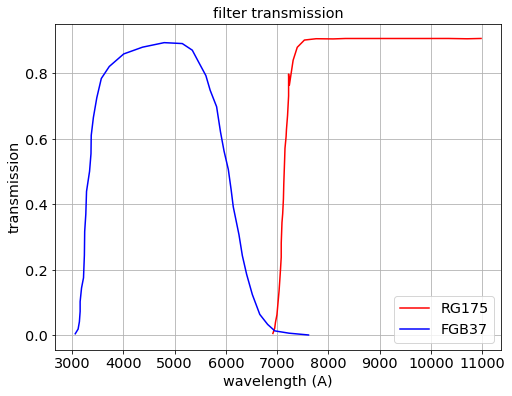

In [30]:
plt.plot(bp_ctio_f_red.wave,bp_ctio_f_red.throughput,color='red',label='RG175')
plt.plot(bp_ctio_f_blue.wave,bp_ctio_f_blue.throughput,color='blue',label='FGB37')
plt.grid()
plt.title('filter transmission')
plt.xlabel('wavelength (A)')
plt.ylabel('transmission')
plt.legend()

### Combine

#### With filter

In [31]:
bp_ctio_red=bp_ctio_qe*bp_ctio_m*bp_ctio_f_red
bp_ctio_blue=bp_ctio_qe*bp_ctio_m*bp_ctio_f_blue

#### witout filter

In [32]:
bp_ctio_nof=bp_ctio_qe*bp_ctio_m

### Please select the bp_ctio below

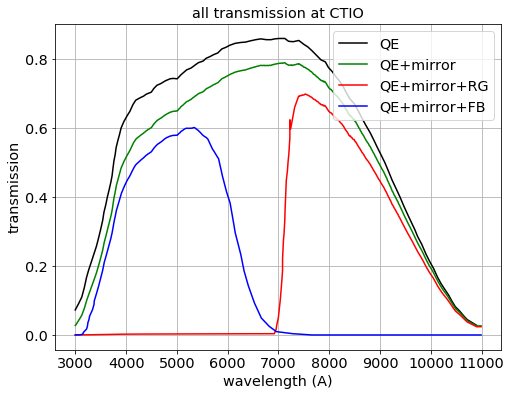

In [33]:
plt.plot(wl_qe*10,tr_qe,'k-',label='QE')
plt.plot(bp_ctio_nof.wave,bp_ctio_nof.throughput,'g-',label='QE+mirror')
plt.plot(bp_ctio_red.wave,bp_ctio_red.throughput,'r-',label='QE+mirror+RG')
plt.plot(bp_ctio_blue.wave,bp_ctio_blue.throughput,'b-',label='QE+mirror+FB')
plt.title('all transmission at CTIO')
plt.xlabel('wavelength (A)')
plt.ylabel('transmission')
plt.grid()
plt.legend()
plt.savefig('all_transmission.pdf')

## Get SED from CALSPEC 

- using Pysynphot

In [34]:
CTIO_COLL_SURF=0.9*(u.m)**2/(u.cm)**2  # LSST collectif surface
WLMIN=3000.
WLMAX=11000.

In [35]:
S.refs.setref(area=CTIO_COLL_SURF.decompose(), waveset=None)
S.refs.set_default_waveset(minwave=WLMIN, maxwave=WLMAX, delta=10, log=False)

# Simulate atmosphere

In [36]:
all_wl_atm= []
all_tr_atm= []
all_bp_atm = []
all_pwv=np.arange(0,10.5,0.5)
OZ=300.
AM=1

In [37]:
for index,pwv in np.ndenumerate(all_pwv):
    idx=index[0]
    #calculate the atmosphere
    path,file=ProcessSimulation(AM,pwv,OZ,Pressure)   
    fullfilename=os.path.join(path,file)
    atm_data=np.loadtxt(fullfilename)
    wl_atm=atm_data[:,0]
    tr_atm=atm_data[:,1]
    all_wl_atm.append(wl_atm)
    all_tr_atm.append(tr_atm)
    atm_filter_name='CTIO atm {}'.format(idx)
    bp_atm = S.ArrayBandpass(wl_atm*10.,tr_atm, name=atm_filter_name)  # Pysynphot pass band
    all_bp_atm.append(bp_atm) 

--------------------------------------------
 2) airmass =  1
 2) pwv =  0.0
 3) oz =  300.0
 4) pressure  =  775.28625
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/CT/pp/us/sa/rt/in/RT_CT_pp_us_sa_rt_z10_wv0_oz30.INP')
('Output to file                : ', 'simulations/RT/2.0.1/CT/pp/us/sa/rt/out/RT_CT_pp_us_sa_rt_z10_wv0_oz30.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/CT/pp/us/sa/rt/in/RT_CT_pp_us_sa_rt_z10_wv0_oz30.INP > simulations/RT/2.0.1/CT/pp/us/sa/rt/out/RT_CT_pp_us_sa_rt_z10_wv0_oz30.OUT')
--------------------------------------------
 2) airmass =  1
 2) pwv =  0.5
 3) oz =  300.0
 4) pressure  =  775.28625
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/CT/pp/us/sa/rt/in/RT_CT_pp_us_sa_rt_z10_wv5_oz30.INP')
('Output to file                : ', 'simulations/RT/2.0.1/CT/pp/us/sa/rt/out/RT_CT

--------------------------------------------
 2) airmass =  1
 2) pwv =  6.5
 3) oz =  300.0
 4) pressure  =  775.28625
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/CT/pp/us/sa/rt/in/RT_CT_pp_us_sa_rt_z10_wv65_oz30.INP')
('Output to file                : ', 'simulations/RT/2.0.1/CT/pp/us/sa/rt/out/RT_CT_pp_us_sa_rt_z10_wv65_oz30.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/CT/pp/us/sa/rt/in/RT_CT_pp_us_sa_rt_z10_wv65_oz30.INP > simulations/RT/2.0.1/CT/pp/us/sa/rt/out/RT_CT_pp_us_sa_rt_z10_wv65_oz30.OUT')
--------------------------------------------
 2) airmass =  1
 2) pwv =  7.0
 3) oz =  300.0
 4) pressure  =  775.28625
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/CT/pp/us/sa/rt/in/RT_CT_pp_us_sa_rt_z10_wv70_oz30.INP')
('Output to file                : ', 'simulations/RT/2.0.1/CT/pp/us/sa/rt/out/

## Observed spectra

- calculate the observed spectra and save it in list

In [38]:
all_obs_spectra = []
all_obs_wl= []
all_obs_fluxes = []

for index,pwv in np.ndenumerate(all_pwv):
    idx=index[0]
     # retrieve the SED
    theobjectname=object_name
    sed_filename = os.path.join(os.environ['PYSYN_CDBS'], 'calspec',calspec_sed[theobjectname])
    sed = S.FileSpectrum(sed_filename)
    
    
    # retrieve the filter
   
    bp_ctio=bp_ctio_red
    #bp_ctio=bp_ctio_blue
    #bp_ctio=bp_ctio_nof
        
    atm_filter_name='CTIO atm {}'.format(idx)
    
    # atmosphere passband
    the_bp_atm= S.ArrayBandpass(all_wl_atm[idx]*10.,all_tr_atm[idx], name=atm_filter_name)  # Pysynphot pass band
    # total passband
    bp_ctio_atm = bp_ctio*the_bp_atm # Multply atm tansmission by CCD QE efficiciency
    bp_ctio_atm.binning=10.
    
    # now compute the observed spectrum
    obs_ctio = S.Observation(sed,bp_ctio_atm)
    
    #backup
    all_obs_spectra.append(obs_ctio)
    all_obs_wl.append(obs_ctio.wave)
    all_obs_fluxes.append(obs_ctio.flux) 
    

((((CTIO QE * CTIO Mirror2) * RG175) * CTIO atm 0)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((((CTIO QE * CTIO Mirror2) * RG175) * CTIO atm 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((((CTIO QE * CTIO Mirror2) * RG175) * CTIO atm 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((((CTIO QE * CTIO Mirror2) * RG175) * CTIO atm 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((((CTIO QE * CTIO Mirror2) * RG175) * CTIO atm 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((((CTIO QE * CTIO Mirror2) * RG175) * CTIO atm 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((((CTIO QE * CTIO Mirror2) * RG175) * CTIO atm 6)) does not have a de

In [39]:
all_len=[len(all_obs_wl[i]) for i in range(len(all_obs_wl))]

In [40]:
min_len=min(all_len)

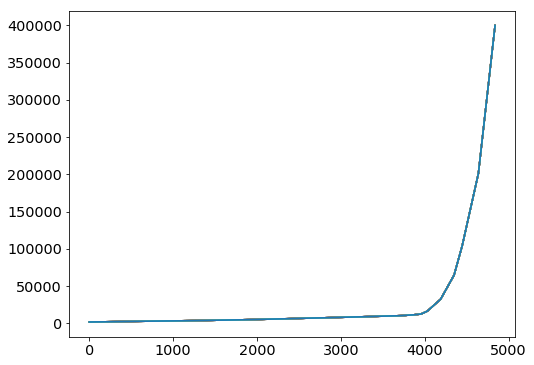

In [41]:
for i in range(len(all_obs_wl)):
    plt.plot(all_obs_wl[i])


In [42]:
def MakeSimNpArray(all_simwavelength,all_simspectra,minlen):
    
    all_simspectra=np.array(all_simspectra)
    simwavelength=np.array(all_simwavelength[0][0:minlen])
    
    NBSPEC=all_simspectra.shape[0]
    NBWL=minlen
    
    print NBSPEC,' , ',NBWL
    dataout=np.zeros((NBSPEC+1,NBWL))
    
    dataout[0,:]=simwavelength
    
    for ispec in np.arange(1,NBSPEC+1):
        dataout[ispec,:]=np.copy(all_simspectra[ispec-1][0:minlen])
    return dataout

In [43]:
spectra_out=MakeSimNpArray(all_obs_wl,all_obs_fluxes,min_len)

21  ,  4840


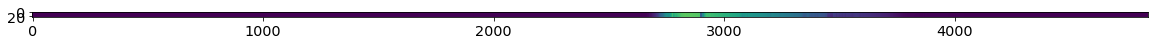

In [44]:
plt.figure(figsize=(20,20))
plt.imshow(spectra_out[:,:],vmin=0,vmax=1e-12)

In [45]:
def CompareSpectrumProfile(allspectra,object_name):
    """
    CompareSpectrumProfile
    =====================
    
    """
    shortfilename='SimuFlux_'+object_name+'_H2O.pdf'
    title="Simulated spectra for {}- Red Filter (LibRadTran)".format(object_name)
    figfilename=shortfilename
    pp = PdfPages(figfilename) # create a pdf file
    
    
    f, axarr = plt.subplots(1,1,figsize=(15,8))
    f.suptitle(title,size=25)
    
    NBSPEC=allspectra.shape[0]-1
    wl=allspectra[0]
    
    
    min_z=truncate(min(all_pwv),2)
    max_z=truncate(max(all_pwv),2)
    
    maxim_y_to_plot= []

    texte='pwv : {} - {} mm '.format(min_z,max_z)
    
    for index in np.arange(0,NBSPEC):
                
        axarr.plot(wl/10.,allspectra[index+1],'-',lw=2)
        maxim_y_to_plot.append(allspectra[index+1].max())
    
    axarr.plot(wl/10.,allspectra[0+1],'r-',lw=2)
    
    max_y_to_plot=max(maxim_y_to_plot)
    axarr.set_ylim(0,max_y_to_plot)
    axarr.text(900.,max_y_to_plot*0.9, texte ,verticalalignment='top', horizontalalignment='left',color='blue',fontweight='bold', fontsize=20)
    axarr.grid(True)
    axarr.set_xlim(600,1100)
    
    axarr.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    #axarr.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    axarr.grid(b=True, which='major', color='grey', linewidth=1.0)
    #axarr.grid(b=True, which='minor', color='grey', linewidth=0.5)
    
    
    
    axarr.set_xlabel("wavelength (nm)",fontsize=30)
    axarr.set_ylabel("relative flux (a.u)",fontsize=30)
    
        
    f.savefig(pp, format='pdf')
    f.show()
    
    pp.close()     
    

In [46]:
import matplotlib 
matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 

/Users/dagoret/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


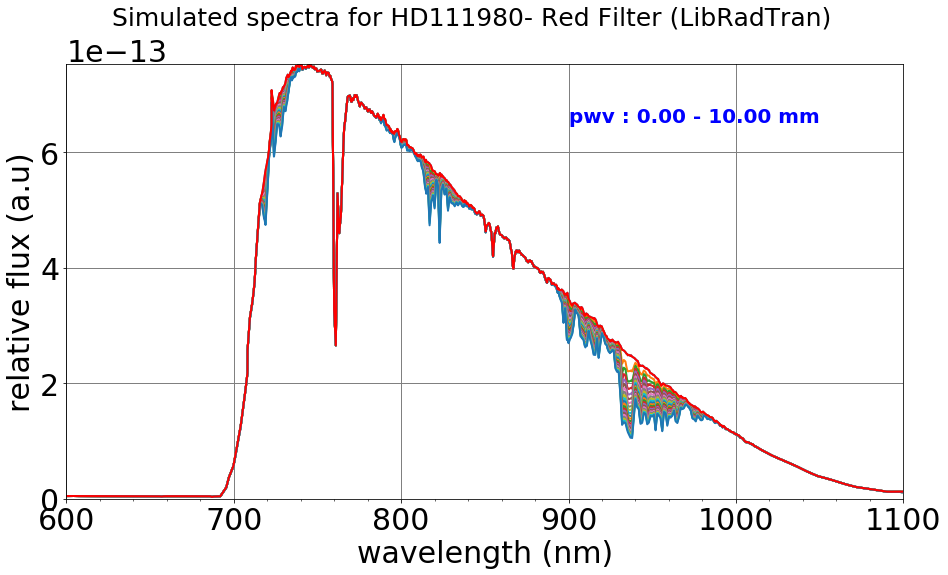

In [47]:
CompareSpectrumProfile(spectra_out,object_name)

## Save output file

In [48]:
prihdr = fits.Header()
prihdr['OBJ_NAME'] = object_name
prihdu = fits.PrimaryHDU(data=spectra_out,header=prihdr)
thdulist = fits.HDUList(prihdu)
thdulist.writeto(outputfitsfile,overwrite=True)

In [49]:
spectra_out.shape

(22, 4840)

In [50]:
outputfitsfile

'spectra_HD111980.fits'